In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("./ObesityDataSet_raw.csv")
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
df.shape

(2111, 17)

In [4]:
df.isna().sum() #no missing values

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df[['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC',
   'CALC', 'MTRANS','NObeyesdad']] = df[['Gender', 'family_history_with_overweight', 'FAVC',
                      'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']].apply(lambda col: le.fit_transform(col))

In [6]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.0,1.62,64.0,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,3,3,1
1,0,21.0,1.52,56.0,1,0,3.0,3.0,2,1,3.0,1,3.0,0.0,2,3,1
2,1,23.0,1.80,77.0,1,0,2.0,3.0,2,0,2.0,0,2.0,1.0,1,3,1
3,1,27.0,1.80,87.0,0,0,3.0,3.0,2,0,2.0,0,2.0,0.0,1,4,5
4,1,22.0,1.78,89.8,0,0,2.0,1.0,2,0,2.0,0,0.0,0.0,2,3,6


In [7]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_std = StandardScaler().fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_std)
np.cumsum(pca.explained_variance_ratio_)


array([0.16278132, 0.27932396, 0.37491235, 0.45971568, 0.53005198,
       0.59670553, 0.658058  , 0.71249852, 0.76370399, 0.81296224,
       0.86039567, 0.90327306, 0.94084042, 0.96588051, 0.98639247,
       1.        ])

### ANOMALY DETECTION

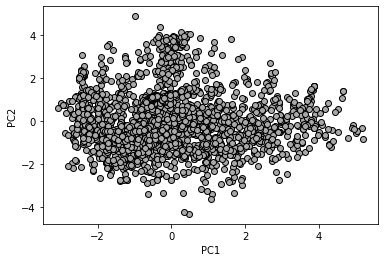

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt

std = StandardScaler()
X_std = std.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

plt.scatter(pd.DataFrame(X_pca).iloc[:, 0],
                pd.DataFrame(X_pca).iloc[:, 1],
                color='darkgrey', edgecolors='black')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

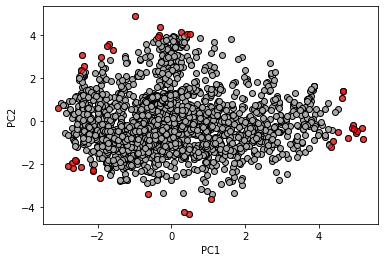

In [9]:
from sklearn.svm import OneClassSVM
from numpy import where

ocsvm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.02)
ocsvm.fit(X_pca)

pred_ocsvm = ocsvm.predict(X_pca)
pred_ocsvm

anom_index = where(pred_ocsvm == -1)
outliers = X_pca[pred_ocsvm == -1]

plt.scatter(pd.DataFrame(X_pca).iloc[:,0], pd.DataFrame(X_pca).iloc[:,1], color = 'darkgrey', edgecolors='black')
plt.scatter(pd.DataFrame(outliers).iloc[:, 0],
                pd.DataFrame(outliers).iloc[:, 1],
                color='red',
                alpha=.6, edgecolors='black')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [10]:
lista = []
for i in anom_index[0]:
    lista.append(i)
outliers.shape

(42, 2)

In [11]:
df = pd.DataFrame(df).drop(lista, axis=0, errors='ignore')
df.shape

(2069, 17)

In [12]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=.2,
                                                    random_state=1)

### Support Vector Machine

In [14]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(StandardScaler(),
                     SVC(random_state=1))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Test Accuracy: %.3f' % accuracy_score(y_pred=y_pred, y_true=y_test))

Test Accuracy: 0.884


In [15]:
from sklearn.model_selection import GridSearchCV

param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = [{'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']},
              {'svc__kernel': ['linear'],
               'svc__C': param_range}
             ]

gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=5,
                  refit=True,
                  n_jobs=-1)

gs.fit(X_train, y_train)
print('Parametri migliori ottenuti dalla GS:', gs.best_params_)

Parametri migliori ottenuti dalla GS: {'svc__C': 1000, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [16]:
best = gs.best_estimator_
best.fit(X_train, y_train)
print('Accuratezza su test set: %.3f' % best.score(X_test, y_test))

Accuratezza su test set: 0.961


In [17]:
y_pred = best.predict(X_test)

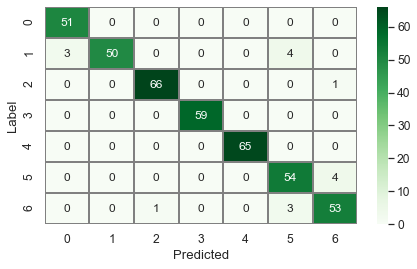

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_mat = pd.DataFrame(conf_mat)
conf_mat.index.name = 'Label'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7,4))
sns.set(font_scale=1.1)#for label size
sns.heatmap(conf_mat, cmap="Greens", annot=True, annot_kws={"size": 12}, linecolor='grey', linewidth=1)

plt.show()

### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(),
                     LogisticRegression(random_state=1, multi_class='ovr', solver='liblinear'))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Test Accuracy: %.3f' % accuracy_score(y_pred=y_pred, y_true=y_test))

Test Accuracy: 0.756


In [20]:
from sklearn.model_selection import GridSearchCV

param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = [{'logisticregression__C': param_range,
               'logisticregression__penalty': ['l1', 'l2']}
             ]

gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=5,
                  refit=True,
                  n_jobs=-1)

gs.fit(X_train, y_train)
print('Parametri migliori ottenuti dalla GS:', gs.best_params_)

Parametri migliori ottenuti dalla GS: {'logisticregression__C': 10, 'logisticregression__penalty': 'l1'}


In [21]:
best = gs.best_estimator_
best.fit(X_train, y_train)
print('Accuratezza su test set: %.3f' % best.score(X_test, y_test))

Accuratezza su test set: 0.797


In [22]:
y_pred = best.predict(X_test)

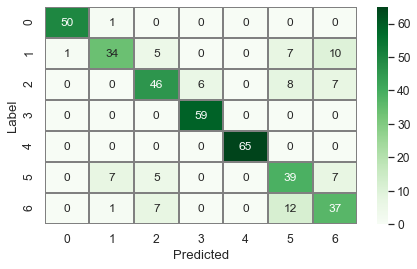

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_mat = pd.DataFrame(conf_mat)
conf_mat.index.name = 'Label'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7,4))
sns.set(font_scale=1.1)#for label size
sns.heatmap(conf_mat, cmap="Greens", annot=True, annot_kws={"size": 12}, linewidth=1, linecolor='grey')

plt.show()

### Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

pipe = make_pipeline(StandardScaler(),
                     DecisionTreeClassifier(random_state=1, max_depth=7))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Test Accuracy: %.3f' % accuracy_score(y_pred=y_pred, y_true=y_test))

Test Accuracy: 0.882


In [25]:
from sklearn.model_selection import GridSearchCV

param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
param_grid = [{'decisiontreeclassifier__max_depth': param_range}]

gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  refit=True,
                  n_jobs=-1)

gs.fit(X_train, y_train)
print('Parametri migliori ottenuti dalla GS:', gs.best_params_)

Parametri migliori ottenuti dalla GS: {'decisiontreeclassifier__max_depth': None}


In [26]:
best_est = gs.best_estimator_
best_est.fit(X_train, y_train)

print('Accuratezza su test set (dopo la GS): %.3f' % best_est.score(X_test, y_test))

Accuratezza su test set (dopo la GS): 0.930


In [27]:
y_pred = best_est.predict(X_test)

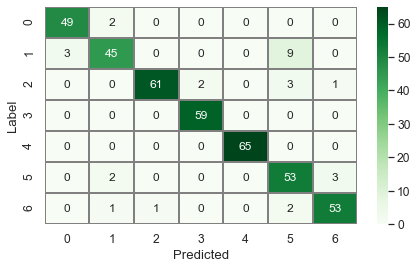

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_mat = pd.DataFrame(conf_mat)
conf_mat.index.name = 'Label'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7,4))
sns.set(font_scale=1.1)#for label size
sns.heatmap(conf_mat, cmap="Greens", annot=True, annot_kws={"size": 12}, linecolor='grey', linewidth=1)

plt.show()

### K-Nearest Neighbor

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

pipeline = make_pipeline(StandardScaler(),
                         KNeighborsClassifier())

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Accuratezza su test set: %.3f" % accuracy_score(y_test, y_pred))

Accuratezza su test set: 0.809


In [30]:
param_range = range(1, 20)
param_grid = [{
    'kneighborsclassifier__n_neighbors':
    param_range,
    'kneighborsclassifier__metric':
    ['euclidean', 'manhattan', 'chebyshev']
}]

gs = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)

gs.fit(X_train, y_train)
print('Parametri migliori ottenuti dalla GS:', gs.best_params_)

Parametri migliori ottenuti dalla GS: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 1}


In [31]:
best_est = gs.best_estimator_
best_est.fit(X_train, y_train)
y_pred = best_est.predict(X_test)
print('Accuracy score su test set (dopo la GS): %.3f' % best_est.score(X_test, y_test))

Accuracy score su test set (dopo la GS): 0.889


In [32]:
y_pred = best_est.predict(X_test)

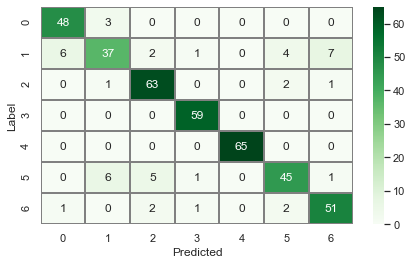

In [33]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_mat = pd.DataFrame(conf_mat)
conf_mat.index.name = 'Label'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7,4))
sns.set(font_scale=1.0)#for label size
sns.heatmap(conf_mat, cmap="Greens", annot=True, annot_kws={"size": 12}, fmt='g', linecolor='grey', linewidth=1)
plt.show()

### Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(StandardScaler(),
                         RandomForestClassifier(n_estimators=10, random_state=1, n_jobs=-1))

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Accuratezza su test set: %.3f" % accuracy_score(y_test, y_pred))

Accuratezza su test set: 0.937


In [36]:
from sklearn.model_selection import GridSearchCV

param_range = [1, 2, 3, 4, 5, 6, 7, None]
param_grid = [{'randomforestclassifier__max_depth': param_range,
               'randomforestclassifier__n_estimators': [10, 100, 1000],
               'randomforestclassifier__criterion': ['gini', 'entropy']}]

gs = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=5,
                  refit=True,
                  n_jobs=-1)

gs.fit(X_train, y_train)
print('Parametri migliori ottenuti dalla GS:', gs.best_params_)

Parametri migliori ottenuti dalla GS: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 1000}


In [37]:
best_est = gs.best_estimator_
best_est.fit(X_train, y_train)
y_pred = best_est.predict(X_test)
print('Accuratezza su test set (dopo la GS): %.3f' % best_est.score(X_test, y_test))

Accuratezza su test set (dopo la GS): 0.954


In [38]:
y_pred = best_est.predict(X_test)

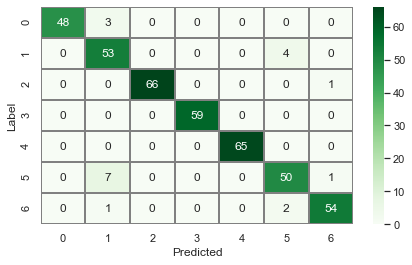

In [39]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_mat = pd.DataFrame(conf_mat)
conf_mat.index.name = 'Label'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7,4))
sns.set(font_scale=1.0)#for label size
sns.heatmap(conf_mat, cmap="Greens", annot=True, annot_kws={"size": 12}, fmt='g', linecolor='grey', linewidth=1)
plt.show()